# Compare NNLS and Ridge

In [1]:
import os
from pathlib import Path
import numpy as np 
from scipy.io import loadmat 
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
import deepdish as dd
import connectivity.constants as const
import connectivity.data as data
import connectivity.model as model
import connectivity.run as run
import SUITPy as suit
import surfAnalysisPy as surf

/Users/jdiedrichsen/.local/share/virtualenvs/cerebellum_connectivity-lV1BGCUV/lib/python3.7/site-packages/nilearn/datasets/__init__.py:90: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


## Look at individual fit for Ridge and NNLS

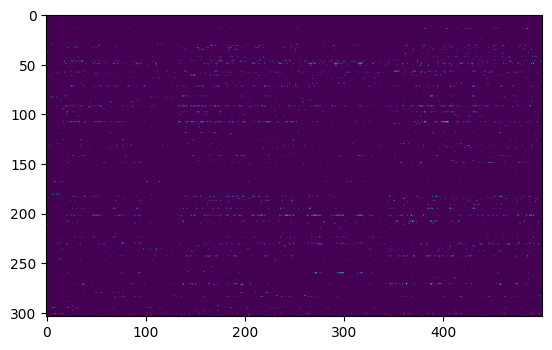

In [2]:
file = os.path.join(const.base_dir,'sc1','conn_models','train','NN_tessels0162_A0','NN_tessels0162_A0_s03.h5')
M=dd.io.load(file)
plt.imshow(M.coef_[:500,:].T)
plt.show()

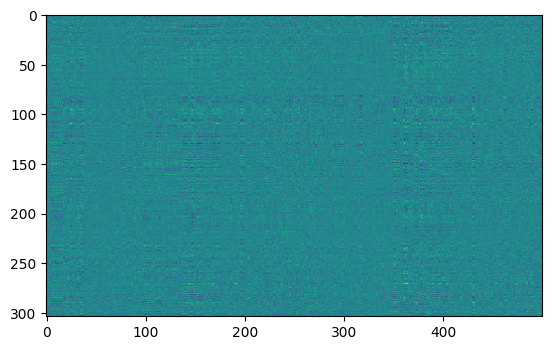

In [19]:
file = os.path.join(const.base_dir,'sc1','conn_models','train','ridge_tessels0162_A0','ridge_tessels0162_A0_s03.h5')
M=dd.io.load(file)
plt.imshow(M.coef_[:500,:].T)
plt.show()

## Display group- and region averaged NNLS model

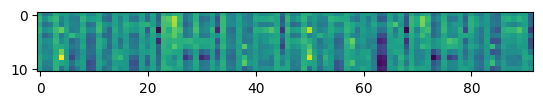

In [3]:
# Load and region average data 
Ydata = data.Dataset(experiment="sc1", roi="cerebellum_suit", subj_id="all")
Ydata.load()
Xdata = data.Dataset(experiment="sc1", roi="tessels0162",subj_id="all")
Xdata.load()

# Read MDTB atlas
index = data.read_suit_nii('/Users/jdiedrichsen/Data/cerebellar_atlases/atl-MDTB/atl-MDTB10_sp-SUIT.nii')
Y, yinfo = Ydata.get_data('sess',True)
X, xinfo = Xdata.get_data('sess',True)
Ym, reg = data.average_by_roi(Y,index)

plt.imshow(Ym.T)
plt.show()

In [4]:
# Fit the NNLS model to region-averaged data
nnROI = model.NNLS(alpha=np.exp(2))
nnROI.fit(X,Ym)
nnROI.coef_.shape

     pcost       dcost       gap    pres   dres
 0:  0.0000e+00  0.0000e+00  3e+02  2e+01  1e+00
 1:  3.4195e-03 -5.6290e-01  1e+01  7e-01  5e-02
 2: -1.8352e-01 -3.2896e-01  1e+00  5e-02  4e-03
 3: -1.9138e-01 -2.7505e-01  1e-01  3e-03  2e-04
 4: -1.9959e-01 -2.2674e-01  3e-02  6e-04  4e-05
 5: -2.0444e-01 -2.1523e-01  1e-02  5e-05  4e-06
 6: -2.0693e-01 -2.1089e-01  4e-03  1e-05  7e-07
 7: -2.0804e-01 -2.1024e-01  2e-03  5e-18  5e-16
 8: -2.0888e-01 -2.0943e-01  6e-04  4e-18  5e-16
 9: -2.0919e-01 -2.0927e-01  7e-05  4e-18  6e-16
10: -2.0924e-01 -2.0925e-01  8e-06  5e-18  6e-16
11: -2.0925e-01 -2.0925e-01  1e-07  3e-18  6e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  0.0000e+00  0.0000e+00  3e+02  2e+01  1e+00
 1: -2.7618e-01 -8.3981e-01  1e+01  8e-01  5e-02
 2: -4.5834e-01 -5.8242e-01  1e+00  7e-02  5e-03
 3: -4.4915e-01 -5.0149e-01  2e-01  1e-02  8e-04
 4: -4.4372e-01 -4.6493e-01  7e-02  3e-03  2e-04
 5: -4.4413e-01 -4.5601e-01  2e-02  5e-04  4e-0

(11, 304)

In [5]:
# Fit Ridge Model to region-averaged data 
ridgeROI= model.L2regression(alpha=np.exp(2))
ridgeROI.fit(X,Ym)
ridgeROI.coef_.shape

(11, 304)

In [6]:
# Load NNLS model to voxel data
file = os.path.join(const.base_dir,'sc1','conn_models','train','NN_tessels0162_A0','NN_tessels0162_A0_all.h5')
nnVOX=dd.io.load(file)
nnVOX.coef_.shape

(6937, 304)

In [7]:
# Fit Ridge to voxel data
ridgeVOX = model.L2regression(alpha=np.exp(2))
ridgeVOX.fit(X,Y)
ridgeVOX.coef_.shape

(6937, 304)

In [8]:
def show_cortex(displaydata,cscale=[-0.015,0.015]): 
    flat=[]
    roi_dir = os.path.join(const.base_dir,'sc1','RegionOfInterest','data','group')
    flat.append(os.path.join(roi_dir,'fs_LR.32k.L.flat.surf.gii'))
    flat.append(os.path.join(roi_dir,'fs_LR.32k.R.flat.surf.gii'))
    gii,_ = data.convert_cortex_to_gifti(displaydata,'tessels0162')
    fig = plt.figure(figsize=(20,8))
    ax = plt.subplot(1,2,1)
    surf.plot.plotmap(gii[0],flat[0],cscale = cscale)
    plt.subplot(1,2,2)
    surf.plot.plotmap(gii[1],flat[1],cscale = cscale)
    plt.show()

In [9]:
reg = 2  # MDTB region to display
cs = [-0.015, 0.015]

### Ridge 

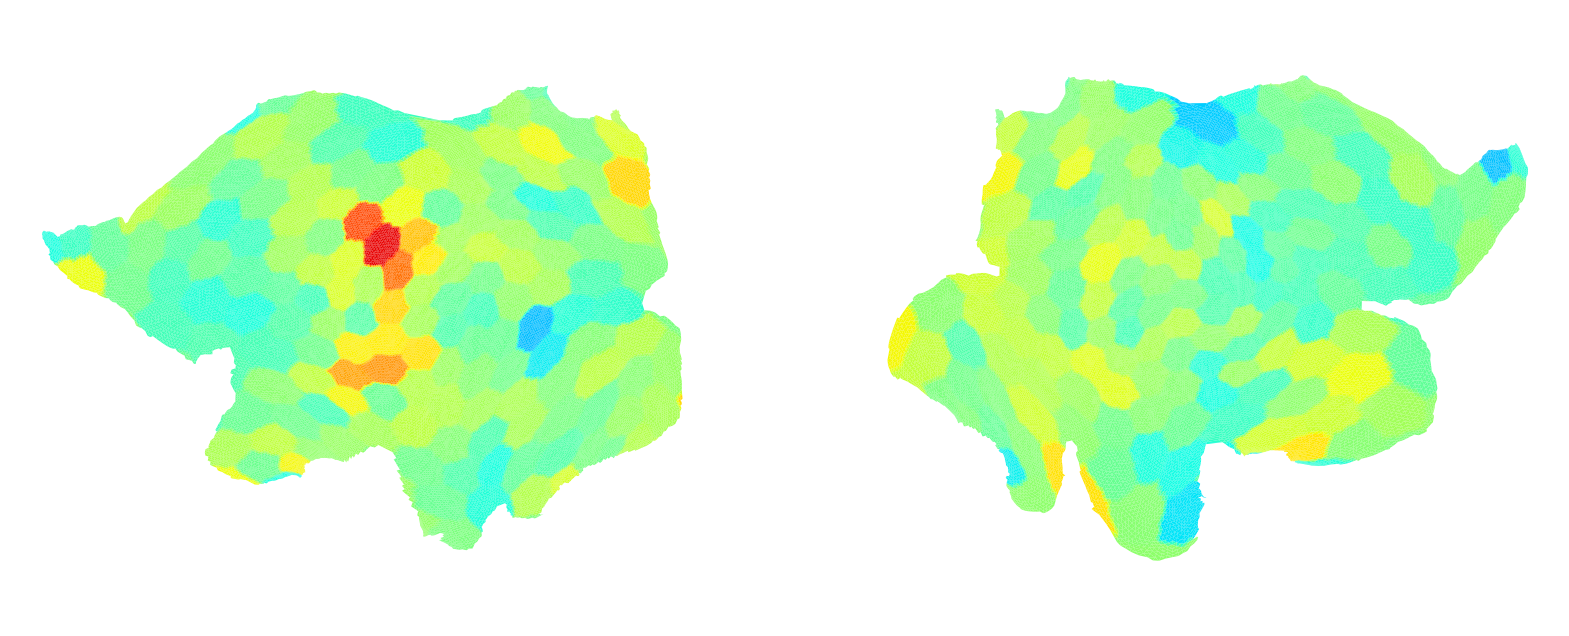

In [10]:
show_cortex(ridgeROI.coef_[reg,:])

### NNLS fitted with cerebellar ROI data and Group data 

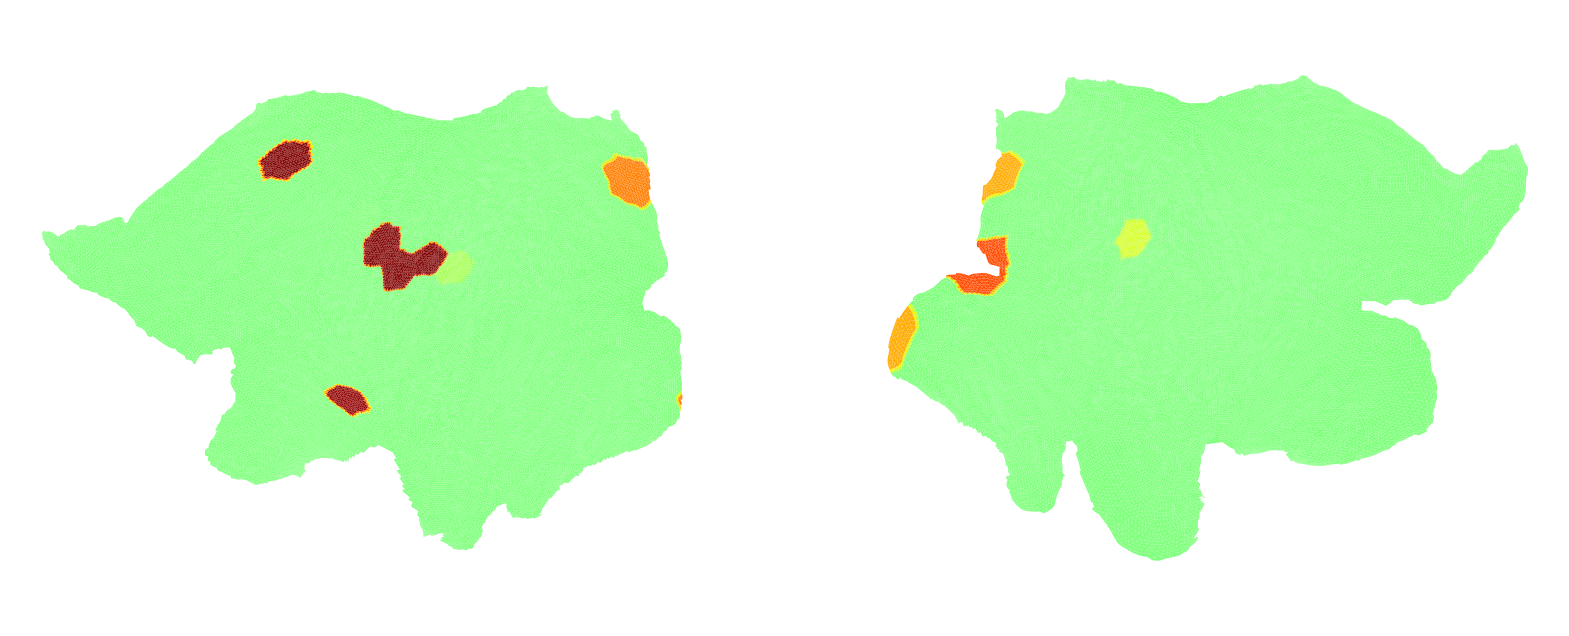

In [50]:
show_cortex(nnROI.coef_[reg,:])

### NNLS fitted with Group data and averaged across voxels 

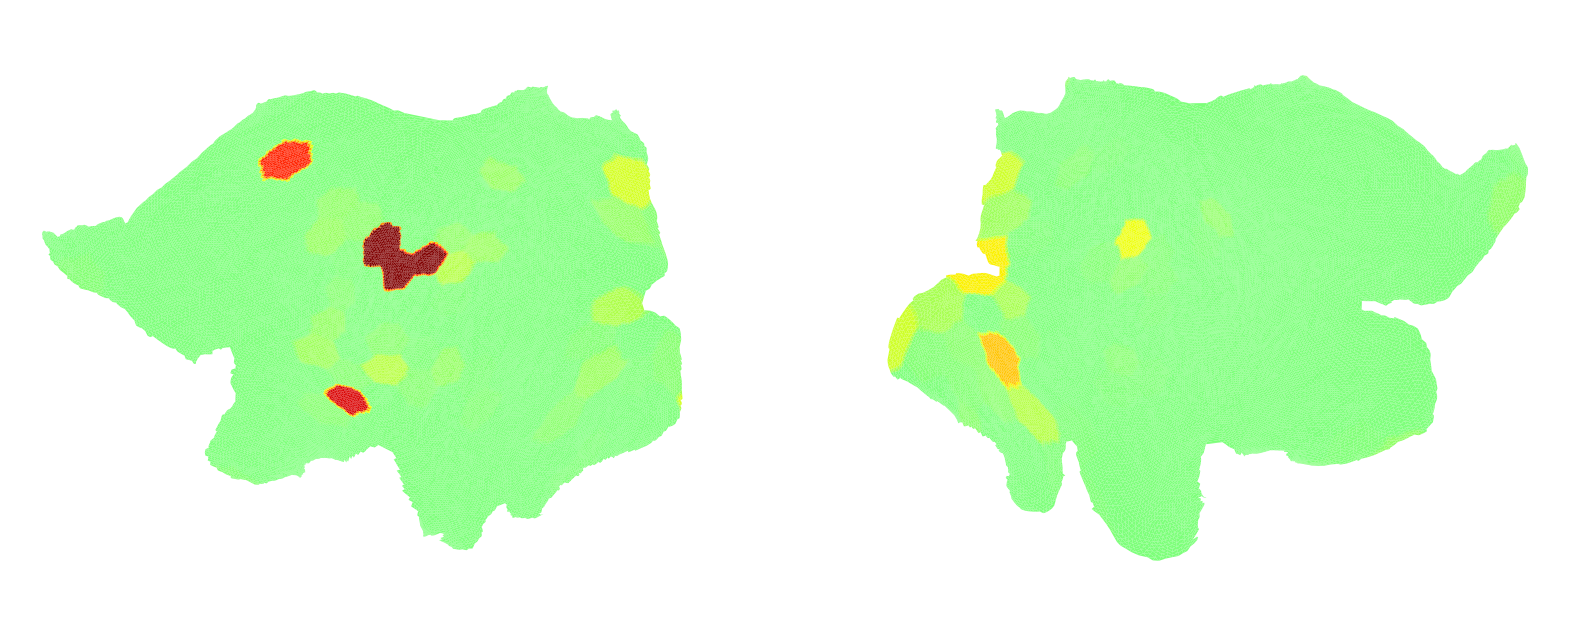

In [51]:
nnVOX_w,_ = data.average_by_roi(nnVOX.coef_.T,index)
show_cortex(nnVOX_w[:,reg])

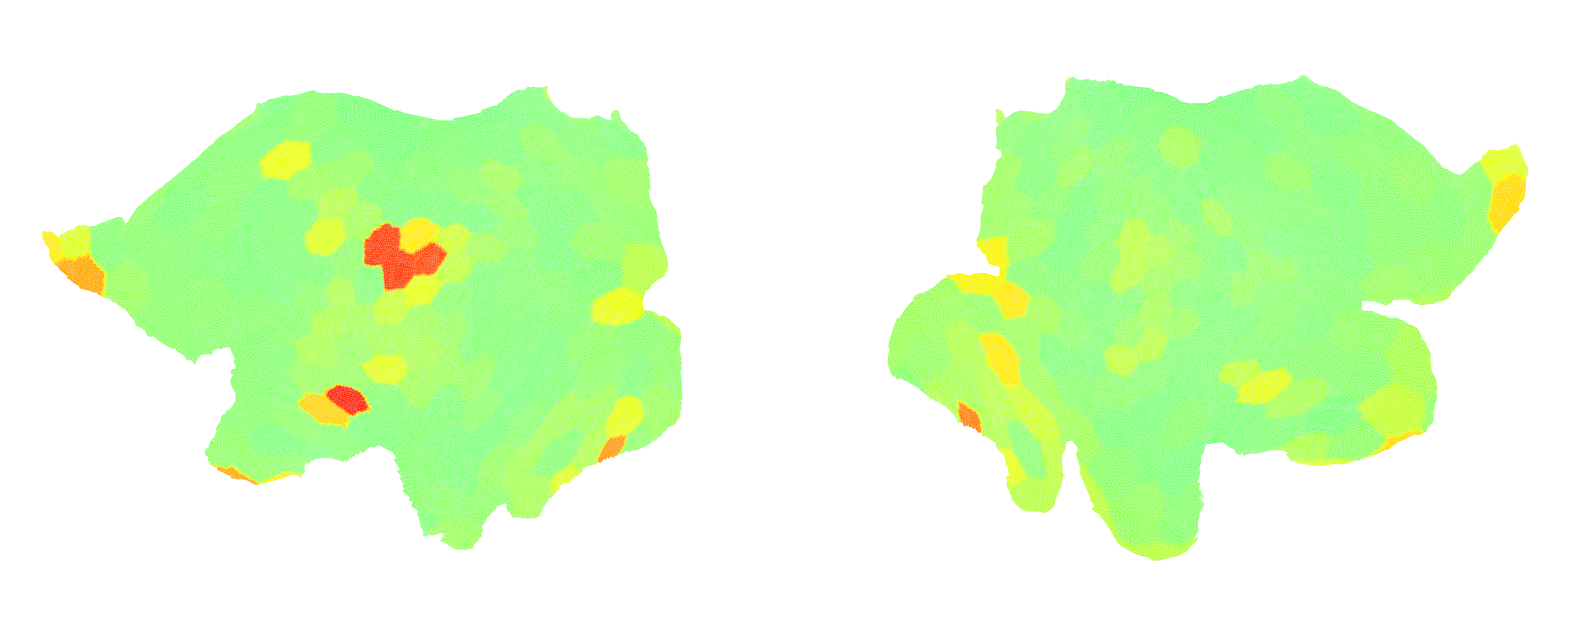

In [11]:
### NNLS average across subjects and voxels in MDTB region 
M = run.average_models('NN_tessels0162_A0','sc1')
nnInd_w,_ = data.average_by_roi(M.coef_.T,index)
show_cortex(nnInd_w[:,reg])

## Evaluate Ridge vs. NN on group data 

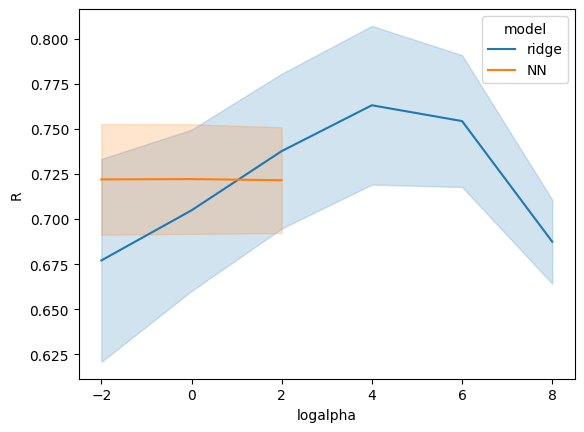

In [47]:
file = os.path.join(const.base_dir,'sc1','conn_models','eval','group_model.dat')
T = pd.read_csv(file)
sb.lineplot(data=T,x='logalpha',y='R',hue='model')
plt.show()